In [1]:
!pip install monai-weekly
!pip install pytorch-ignite

     |████████████████████████████████| 714 kB 5.4 MB/s 
     |████████████████████████████████| 240 kB 5.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import logging
import os
import sys
import shutil
import time
import glob

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, ImageDataset, Dataset, decollate_batch
from monai.data import (
    ArrayDataset, GridPatchDataset, PatchIter)
from monai.utils import first
from monai.transforms import (
    ResizeWithPadOrCropd,
    RandFlipd,
    EnsureChannelFirst,
    EnsureChannelFirstd,
    AsDiscrete,
    SpatialCropd,
    RandCropByPosNegLabeld,
    RandSpatialCropd,
    RandSpatialCropSamplesd,
    CropForeground,
    CropForegroundd,
    RandGaussianNoised,
    Spacing,
    Spacingd,
    AddChannel,
    Compose,
    LoadImage,
    Resize,
    #EnsureType,
    Randomizable,
    LoadImaged,
    EnsureType,
    EnsureTyped,    
    AddChanneld,
    RandAffined,
    Resized,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    MapTransform,
    RandSpatialCropd,
    CenterSpatialCropd,
    Orientationd,
    Invertd,
    AsDiscreted
)


from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.utils import set_determinism
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.handlers.utils import from_engine

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.9.dev2150
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 5cfb3addebf8eca5d191c4e63384c3f513221b5b

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [8]:
root_dir = '/content/drive/MyDrive/'
root_dir2 = '/content/drive/MyDrive/Digital_image_processing/project'

data_dir = os.path.join(root_dir2, "brats18_train")
if os.path.exists(root_dir2):
  print("경로 존재")
else: 
  print("경로 존재x")


경로 존재


In [9]:
print(data_dir)

/content/drive/MyDrive/Digital_image_processing/project/brats18_train


In [10]:
# glob.glob : 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다. 
# '*'는 임의 길이의 모든 문자열을 의미한다.
# 같은 길이의 리스트를 같은 인덱스끼리 잘라서 리스트로 반환을 해주는 역할을 한다.



# train data와 validation data만들기

train_images = sorted(
    glob.glob(os.path.join(data_dir, "Brats18_*", "t1ce.nii.gz"))) # image data에 대한 경로만 전부 sorting 해서 리스트 형식으로 저장
train_labels = sorted( 
    glob.glob(os.path.join(data_dir, "Brats18_*", "label.nii.gz"))) # label data에 대한 경로만 전부 sorting 해서 리스트 형식으로 저장
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)  # 모든 데이터들의 경로를 image와 label pair를 딕셔너리 형태로 만들어준다
]

train_files = []
val_files = []
for i in range(len(data_dicts)):
  if i % 5 == 0:
    val_files.append(data_dicts[i])
  else :
    train_files.append(data_dicts[i])

# 전체 데이터에 대해 train_files과 val_file로 비율을 설정하여 나누어 준다(80:20)

In [11]:
print(len(train_images))
print(len(train_labels))
print(data_dicts[:5])

print(len(train_files))
print(train_files[:5])
print(len(val_files))

100
100
[{'image': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Brats18_2013_11_1/t1ce.nii.gz', 'label': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Brats18_2013_11_1/label.nii.gz'}, {'image': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Brats18_2013_13_1/t1ce.nii.gz', 'label': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Brats18_2013_13_1/label.nii.gz'}, {'image': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Brats18_2013_17_1/t1ce.nii.gz', 'label': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Brats18_2013_17_1/label.nii.gz'}, {'image': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Brats18_2013_19_1/t1ce.nii.gz', 'label': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Brats18_2013_19_1/label.nii.gz'}, {'image': '/content/drive/MyDrive/Digital_image_processing/project/brats18_train/Br

In [12]:
set_determinism(seed=0)

* transforms 적용


In [14]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), 
        EnsureChannelFirstd(keys=["image", "label"]),  
        ScaleIntensityRanged(   
            keys=["image"], a_min=-50, a_max=850, 
            b_min=0.0, b_max=1.0, clip=True,  
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"), #이미지의 foreground object만 자릅니다.
        RandCropByPosNegLabeld(       #Pos Neg 비율을 기준으로 중심이 foreground 또는 background voxel인 임의의 고정된 크기의 영역을 자릅니다. 
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64,64,32), #crop할 영역의 크기
            pos=4,                #"neg"와 함께 사용하여 background voxel이 아닌 전경 voxel을 중심으로 선택할 확률에 대한 비율  pos / (pos + neg)를 계산합니다.
            neg=1,
            num_samples=4,
            image_key="image",       #crop reigion의 개수
            image_threshold=0,       #유요한 이미지 영역을 결정합니다.
        ),
     
        RandSpatialCropd(
                keys=["image","label"],
                roi_size = [64,64,32],
                random_size = False,
            ),
        

        RandFlipd(
                keys= ["image", "label"],
                prob = .5,
                spatial_axis=(0,1,2),
            ),
      
        RandGaussianNoised(
                keys=["image"],
                prob=0.5,
                mean=0,
                std=.001,
            ),
     
#        RandShiftIntensityd(keys="image", offsets=0.5, prob=0.3),
        
        EnsureTyped(keys=["image", "label"]), # 인풋 데이터가 PyTorch 텐서 또는 numpy array가 되도록한다
    ]
)

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([1, 64, 64, 32])


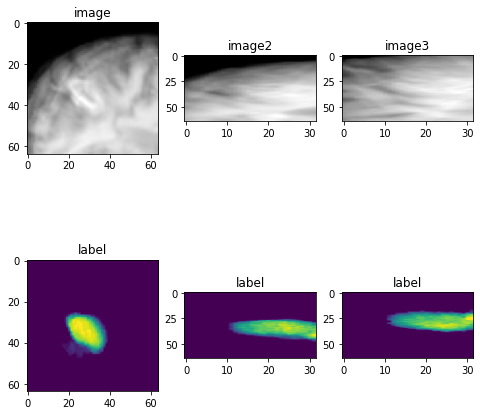

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([1, 64, 64, 32])


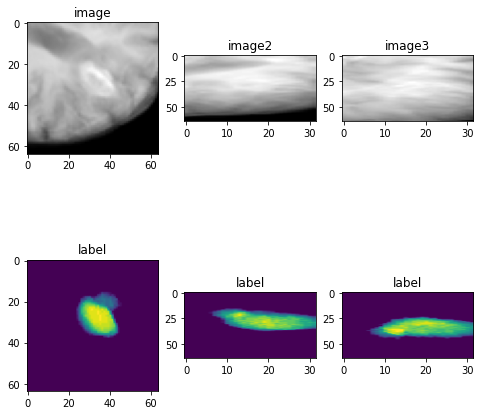

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([1, 64, 64, 32])


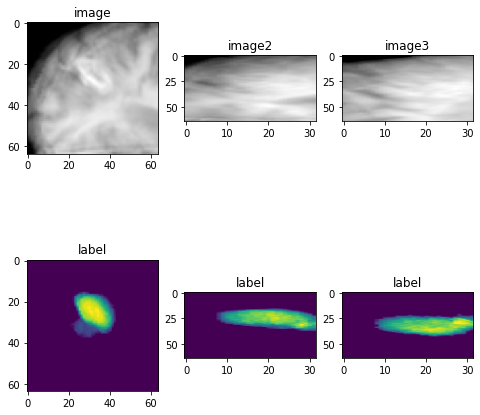

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([1, 64, 64, 32])


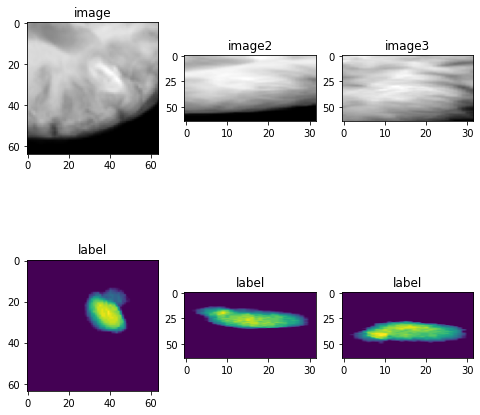

In [15]:
check_ds = Dataset(data = train_files[:4], transform = train_transforms) 
check_loader = DataLoader(check_ds, batch_size = 1)
check_data = first(check_loader)
#.permute(1, 0, 2)  .permute(0,2,1,3)

for n in range(len(check_data['image'])):
      image = check_data["image"][n][0]
      label = check_data["label"][n]

      print(f"image shape: {image.shape}, "
            f"label shape: {label.shape}")


      plt.figure("check", (8, 8))
      plt.subplot(2, 3, 1)
      plt.title("image")
      plt.imshow(torch.sum(image,axis=2), cmap="gray")

      plt.subplot(2, 3, 2)
      plt.title("image2")
      plt.imshow(torch.sum(image,axis=1), cmap="gray",aspect = 1/4)

      plt.subplot(2, 3, 3)
      plt.title("image3")
      plt.imshow(torch.sum(image,axis=0), cmap="gray",aspect = 1/4)

      plt.subplot(2, 3, 4)
      plt.title("label")
      plt.imshow(torch.sum(torch.sum(label[:,:, :, :],axis=3),axis=0))
    
      plt.subplot(2, 3, 5)
      plt.title("label")
      plt.imshow(torch.sum(torch.sum(label[:,:, :, :],axis=2),axis=0),aspect = 1/4)
        
      plt.subplot(2, 3, 6)
      plt.title("label")
      plt.imshow(torch.sum(torch.sum(label[:,:, :, :],axis=1),axis=0),aspect = 1/4)
    
      plt.show()

In [16]:
val_transforms = Compose(
        [
            LoadImaged(keys=["image","label"]),   
            EnsureChannelFirstd(keys=["image", "label"]),     

#            RandSpatialCropd(
#                keys=["image","label"],
#                roi_size = [384,384,64],
#                random_size = False
#            ),
          
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-50, a_max=850, b_min=0.0, b_max=1.0,
                clip=True,
            ), 
          
            CropForegroundd(keys=["image", "label"], source_key="image"),
            EnsureTyped(
                keys=["image","label"]
            ),
        ])

image shape: torch.Size([240, 240, 155]), label shape: torch.Size([240, 240, 155])


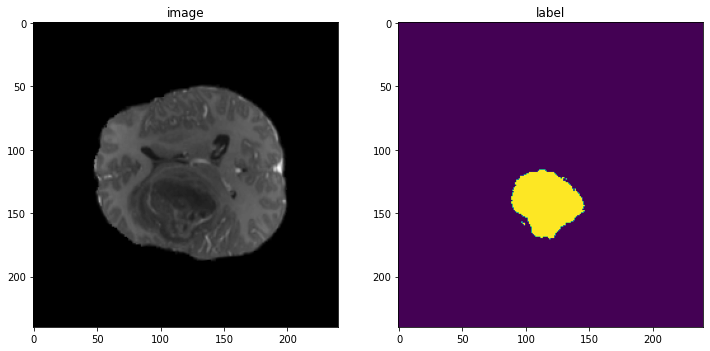

In [18]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
zz = np.argmax(np.sum(np.sum(np.array(label),axis=1),axis=0))
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:,:,zz], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:,:,zz])
plt.show()

In [19]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

Loading dataset: 100%|██████████| 80/80 [00:22<00:00,  3.60it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(len(val_loader))

20


* 모델

In [21]:
from monai.networks.layers import Norm

# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [22]:
model.load_state_dict(torch.load(f'{root_dir2}/best_metric_model.pth'))

<All keys matched successfully>

In [ ]:
max_epochs = 300  # epochs수 
val_interval = 2 # 몇 번 마다validation 할건지
best_metric = -1 #
best_metric_epoch = -1 #
epoch_loss_values = [] # epoch마다 계산되는 loss값 저장
metric_values = [] #
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)]) #
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)]) #

for epoch in range(max_epochs):
    stime = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train() #모듈을 training mode로 설정.
    epoch_loss = 0 # epoch loss값 저장
    step = 0 # 
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        #Pytorch에서는 gradients값들을 추후에 backward를 해줄때 계속 더해주기
        # 때문에 우리는 항상 backpropagation을 하기전에 gradients를 zero로 만들
        #어주고 시작을 해야합니다???
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward() #backpropagation을 하기 위해  결과적으로 나온 loss에 대해서 .backward()를 통해서 뒤로 보내줌
        optimizer.step() #parameter 업데이트
        epoch_loss += loss.item() #average loss를 구하기 위해 해당 epoch에서 구한 loss 를 더해줌
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, " # step / (32//2)
            f"train_loss: {loss.item():.4f}") 
    epoch_loss /= step # average loss 계산
    epoch_loss_values.append(epoch_loss) # epoch average loss 를 저장 해놓는 list에 추가
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0: # 짝수 번째 epoch에서 모델 vlaidation
        model.eval() #모듈을 evaluation mode로 설정(계산에 필요한 메모리 소모량을 줄일 수 있음)
        with torch.no_grad(): # gradinet 계산하지 않음(when you are surethat you will not call Tensor.backward())
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (64, 64, 32) #단위가 무엇인지 확인해보고 바꿔보면서 해보도록
                sw_batch_size = 4         #window slices를 실행할 batch size.
                val_outputs = sliding_window_inference(         #validation output
                    val_inputs, roi_size, sw_batch_size, model) 
                #3. patch를 이용해 모델을 학습한 후에, 그 모델을 활용할 때에는 patch에 대한 결과가 아니라
                                                    # 전체 영상에 대한 결과를 얻는 것을 원합니다.
                                                    # 큰 영상데이터를 patch단위로 결과를 보는 것을 쉽게 해주는 함수입니다.
                                                    # window는 patch라고 보면 됩니다
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item() #?
            print(f"metric : {metric}")
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:       #현재 mean dice result가 가장 좋다면 best_metric으로 저장
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join( #지정해준 PATH에 최상의 dice 값에 대한 모델 weight를 파일에 저장
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}" 
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
                
            )            
    print(f"1 epoch time : {(time.time() - stime) / 60} min")

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))] #x축 범위
y = epoch_loss_values #y 좌표 값
plt.xlabel("epoch") # x축 이름
plt.plot(x, y) #plot
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))] #x축 범위
y = metric_values #y 좌표 값
plt.xlabel("epoch")
plt.plot(x, y) #plot
plt.show() ## 모든 Figure를 display한다.             
plt.savefig(f"{root_dir}/the_loss_and_metric.png") 

----------
epoch 1/300


/usr/local/lib/python3.7/dist-packages/monai/transforms/post/array.py:177: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/20, train_loss: 0.1692
2/20, train_loss: 0.2994
3/20, train_loss: 0.2275
4/20, train_loss: 0.1301
5/20, train_loss: 0.2356
6/20, train_loss: 0.2094
7/20, train_loss: 0.1479
8/20, train_loss: 0.2738
9/20, train_loss: 0.2486
10/20, train_loss: 0.2367
11/20, train_loss: 0.2083
12/20, train_loss: 0.1411
13/20, train_loss: 0.1987
14/20, train_loss: 0.2964
15/20, train_loss: 0.1993
16/20, train_loss: 0.1507
17/20, train_loss: 0.2169
18/20, train_loss: 0.2709
19/20, train_loss: 0.2390
20/20, train_loss: 0.3258
epoch 1 average loss: 0.2213
1 epoch time : 0.425856073697408 min
----------
epoch 2/300
1/20, train_loss: 0.2243
2/20, train_loss: 0.2051
3/20, train_loss: 0.2374
4/20, train_loss: 0.1676
5/20, train_loss: 0.2570
6/20, train_loss: 0.2252
7/20, train_loss: 0.2567
8/20, train_loss: 0.2071
9/20, train_loss: 0.2265
10/20, train_loss: 0.1809
11/20, train_loss: 0.1585
12/20, train_loss: 0.1619
13/20, train_loss: 0.1359
14/20, train_loss: 0.2151
15/20, train_loss: 0.3275
16/20, train_loss: 

* validation inference

In [ ]:
import nibabel as nib

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


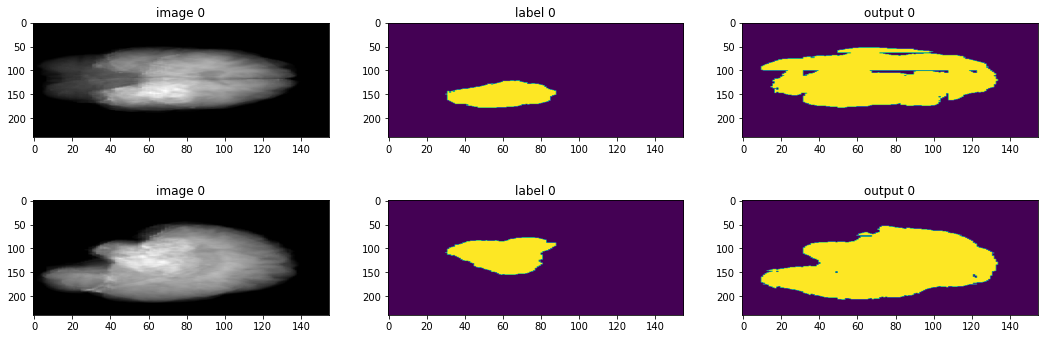

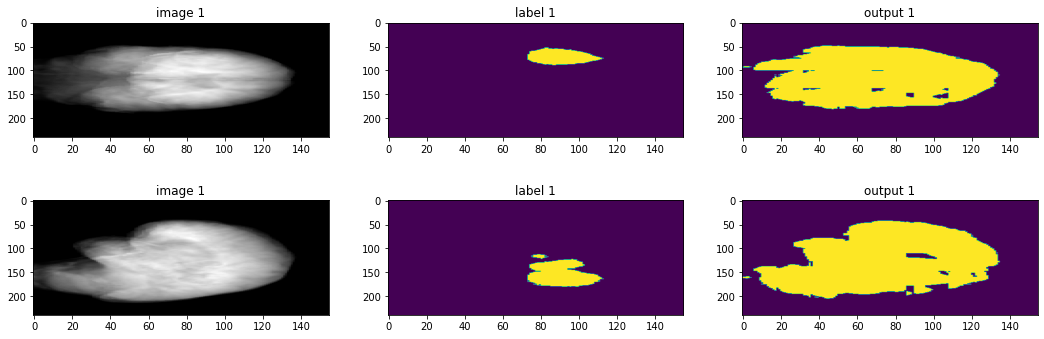

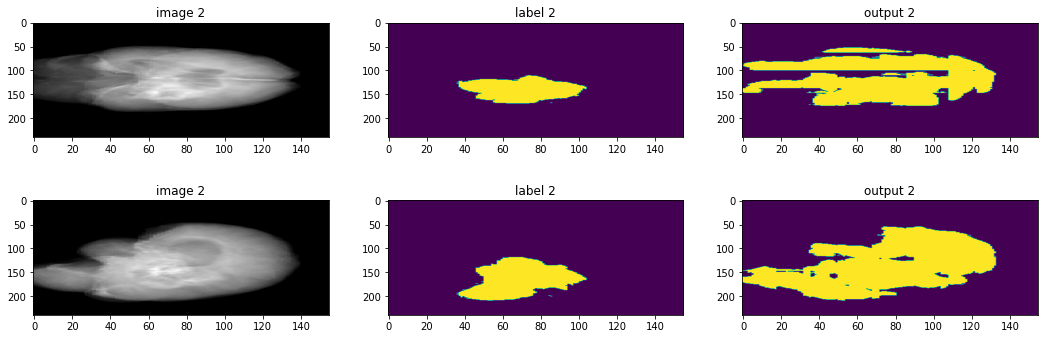

In [ ]:
flag_niisav = 0

model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 32)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model, overlap=0.42
        )
        tmp = val_data["label"]
        zz = np.argmax(np.sum(np.sum(np.array(tmp[0,0,:,:,:]),axis=1),axis=0))

        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(2, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=1), cmap="gray",aspect=1/4)
        plt.subplot(2, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(torch.amax(val_data["label"][0, 0, :, :, :],dim=1),aspect=1/4)
        plt.subplot(2, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=1),aspect=1/4)
        plt.subplot(2, 3, 4)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=0), cmap="gray",aspect=1/4)
        plt.subplot(2, 3, 5)
        plt.title(f"label {i}")
        plt.imshow(torch.amax(val_data["label"][0, 0, :, :, :],dim=0),aspect=1/4)
        plt.subplot(2, 3, 6)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=0),aspect=1/4)        
#        val_outs = torch.argmax(val_outputs, dim=1).detach().cpu()
#        plt.imshow(np.sum(val_outs[0,:,:,:].numpy(),axis=2))
        plt.show()
    
        if flag_niisav == 1:
            #outdir = val_data['image_meta_dict']['filename_or_obj'][0].split('ct_post')[0]
            outdir='/content/drive/MyDrive/nifti_save/'
            print(outdir)

            h0 = nib.Nifti1Image(val_data['image'][0,0].cpu().numpy(),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h0,os.path.join(outdir,f'IMAGE.nii.gz'))             
            h1 = nib.Nifti1Image(val_outputs.cpu().softmax(1)[0,1].numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h1,os.path.join(outdir,f'LABEL.nii.gz'))  
            h2 = nib.Nifti1Image(torch.argmax(val_outputs.cpu(), dim=1).numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h2,os.path.join(outdir,f'OUTPUT.nii.gz'))            
        if i==2:
            break

# test

In [ ]:
data_dir = '/content/drive/MyDrive/brats18_test'

import os

if os.path.exists(data_dir):    # 지정된 경로가 존재하는지 여부를 확인
    print("경로 존재")
else:
    print("경로 존재X")

경로 존재


In [ ]:
data_dirr='/content/drive/MyDrive/nifti_save2/'
best_metric='/content/drive/MyDrive/'

  Created wheel for tmp: filename=tmp-0.0.2-py3-none-any.whl size=1998 sha256=59414bb2ae58352d45e8f0eff7b2d4512ead35e7d71578d0a2d386b7a3239f02
  Stored in directory: /root/.cache/pip/wheels/6d/94/70/0e8344e8a10ec2eb57629a037765267a6254dac7f51f724db0
Successfully built tmp
MONAI version: 0.9.dev2149
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1ad68787c35e259cb7704b56d679659104d2494c

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.mona

Loading dataset: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


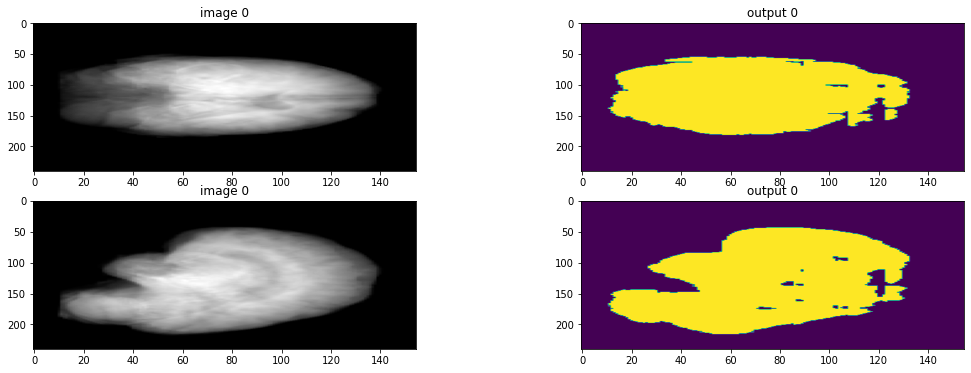

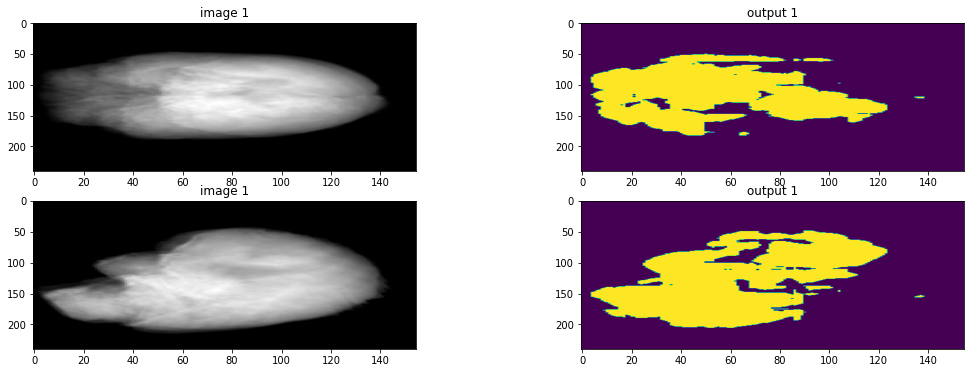

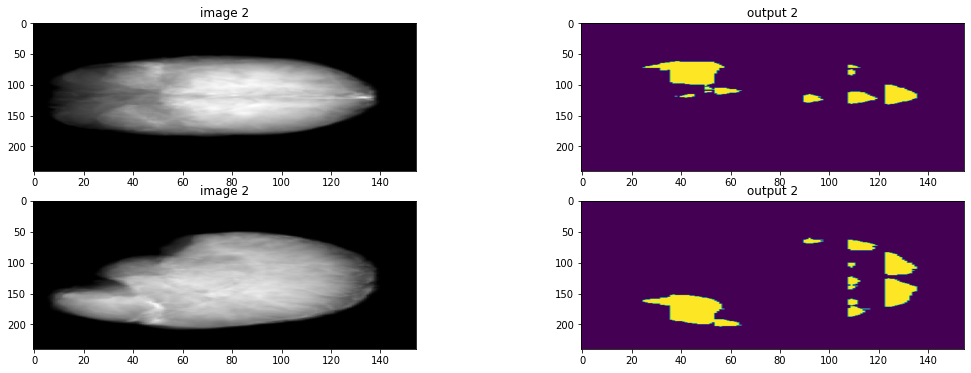

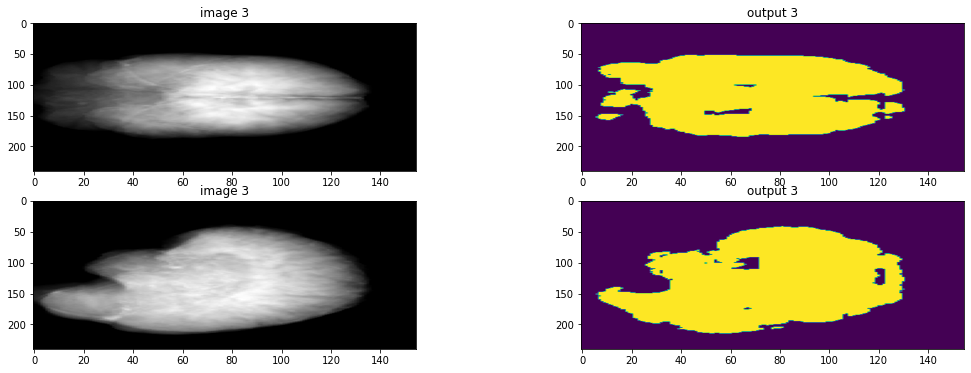

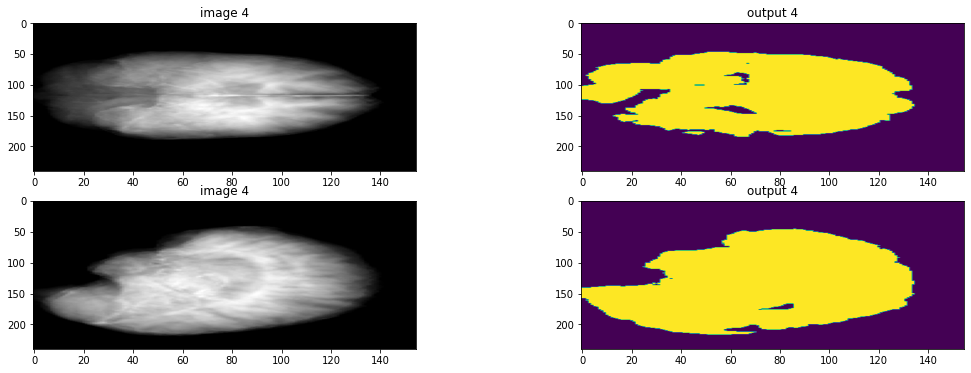

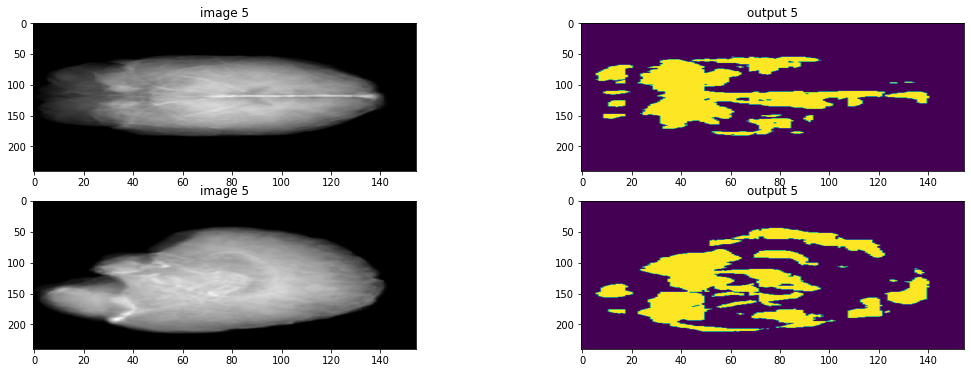

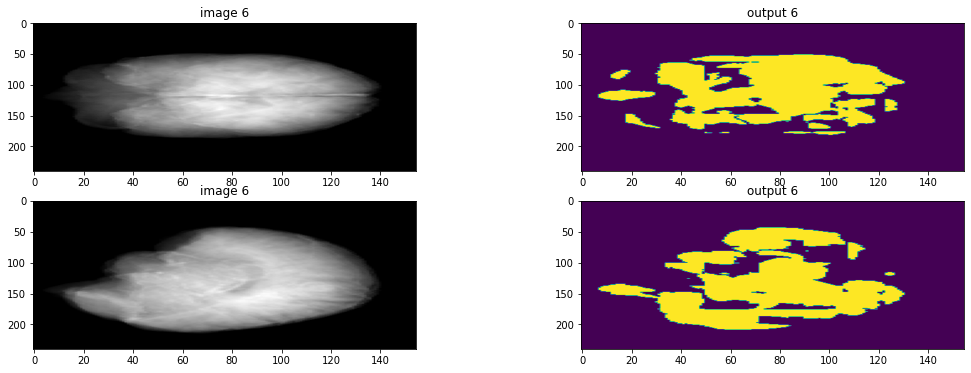

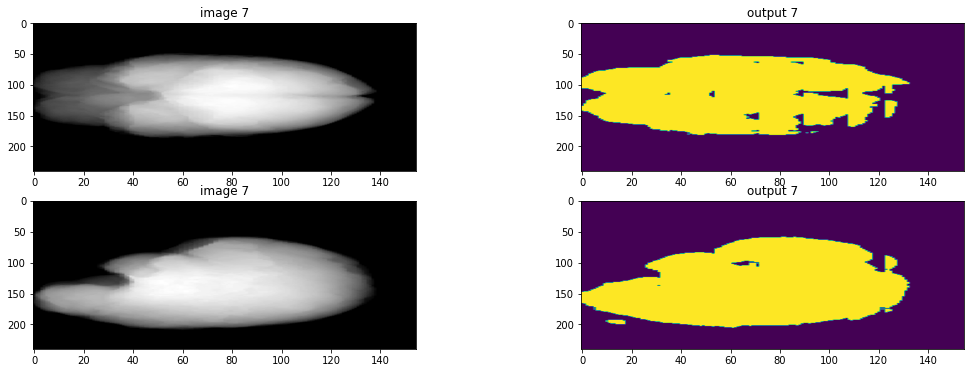

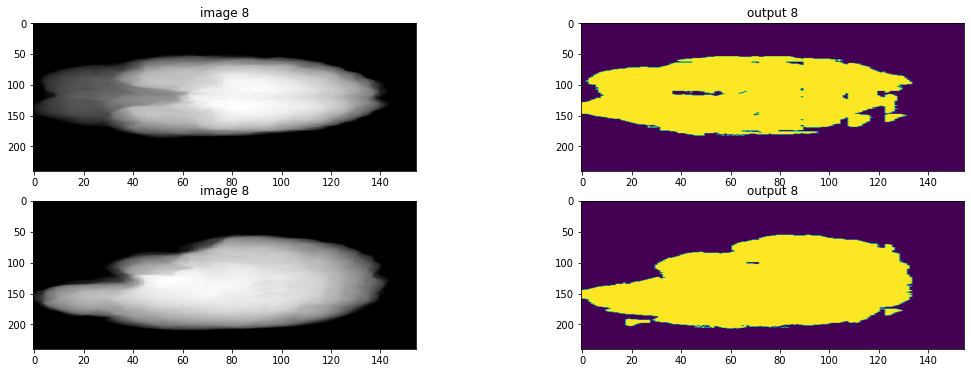

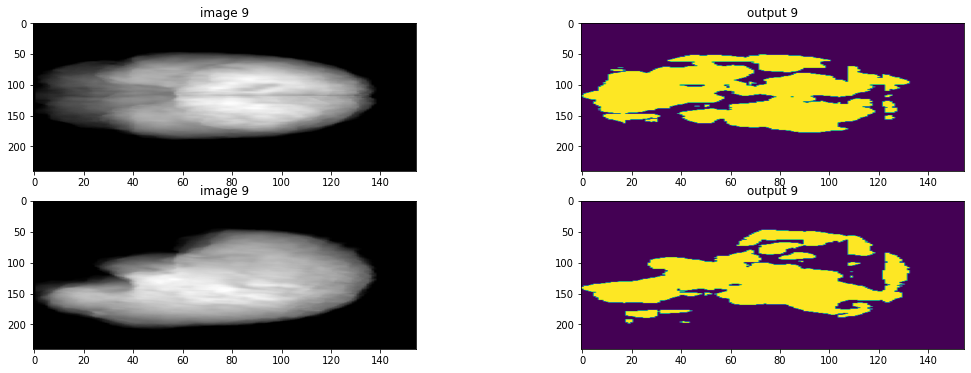

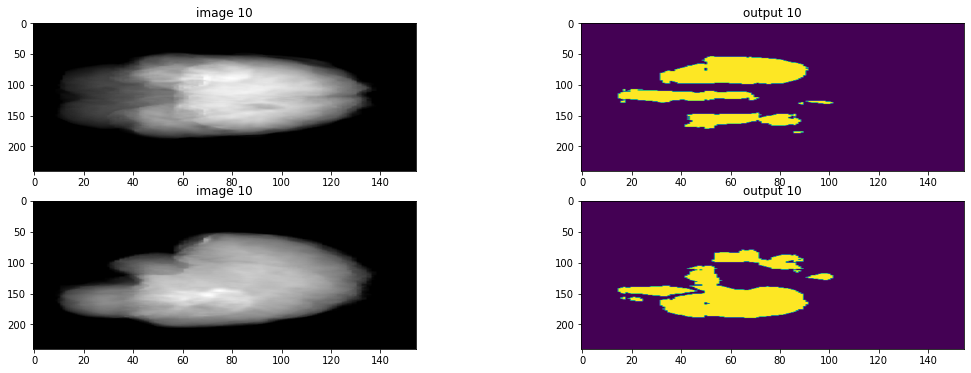

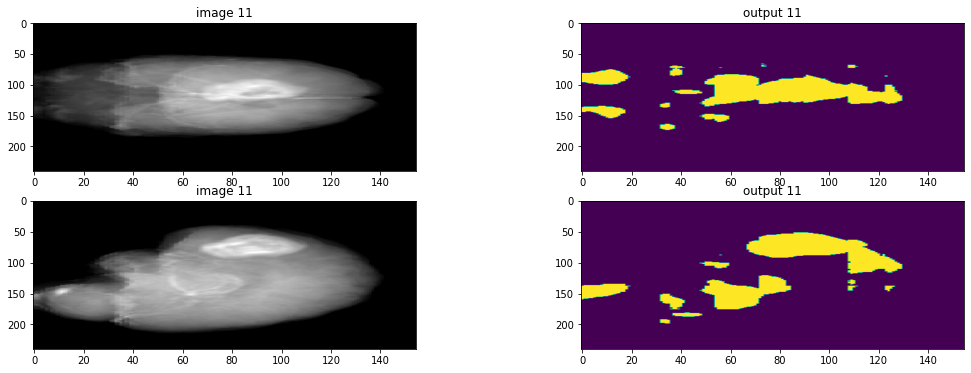

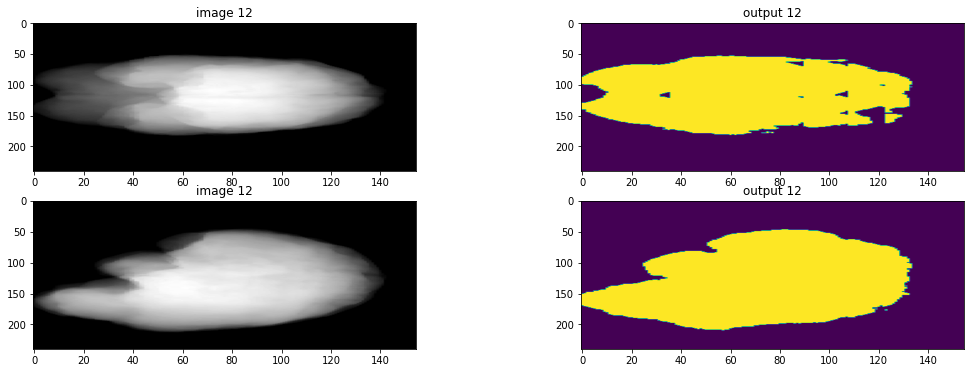

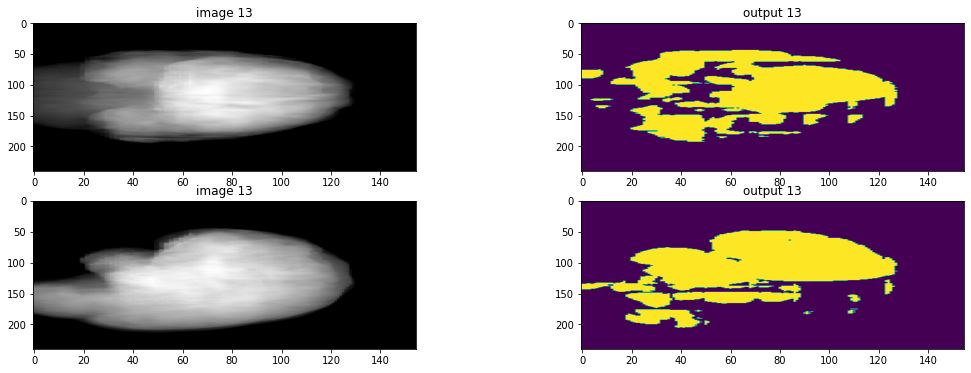

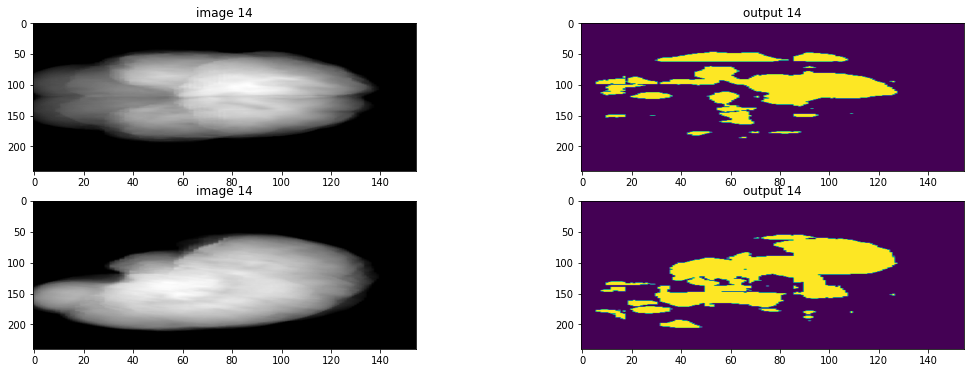

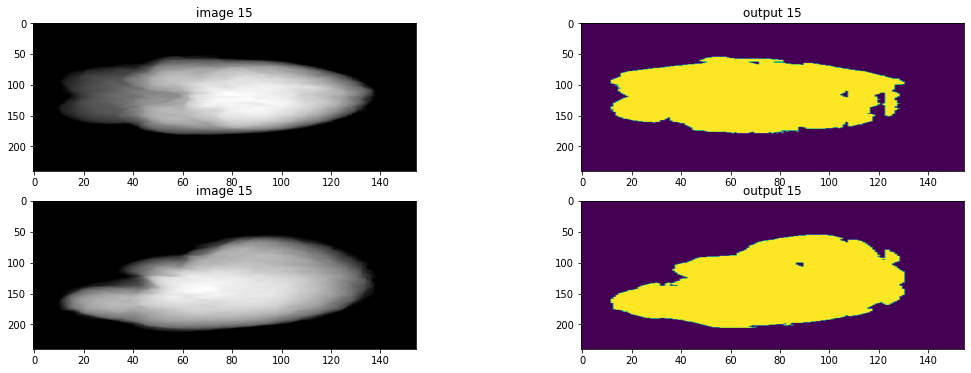

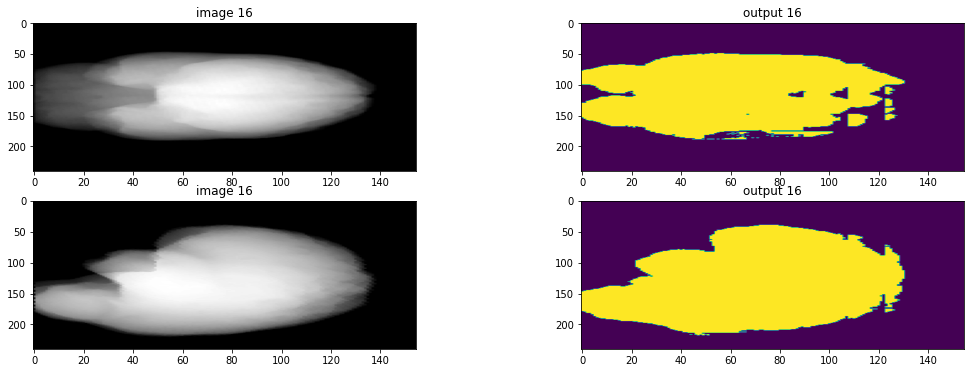

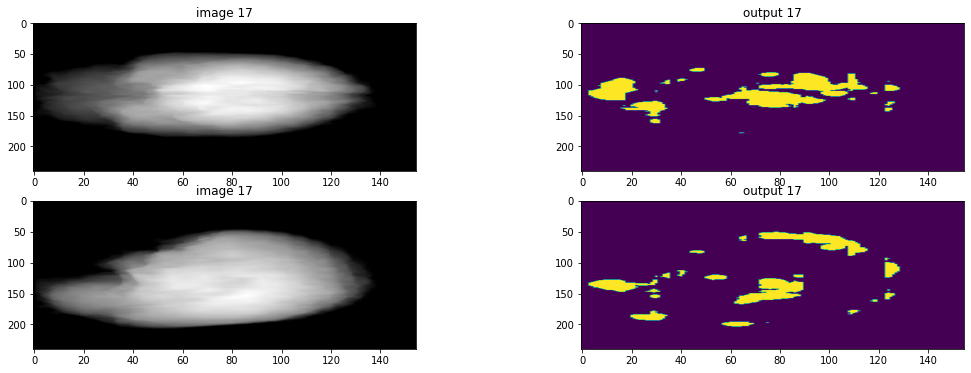

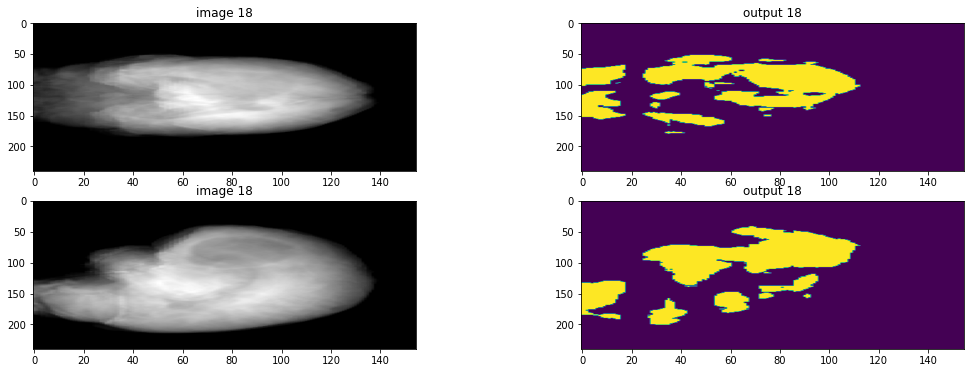

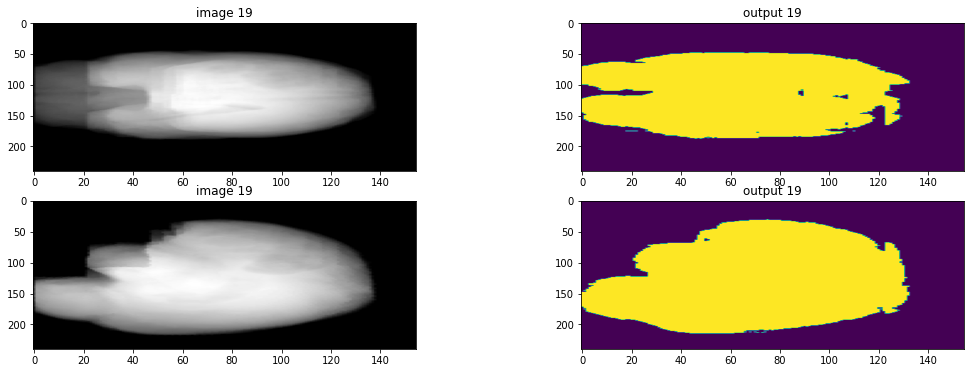

In [ ]:
!pip install monai-weekly
!pip install pytorch-ignite
!pip install tmp

import logging
import sys
import shutil
import time
import tmp

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, ImageDataset, Dataset,decollate_batch
from monai.data import (
    ArrayDataset, GridPatchDataset,  PatchIter)
from monai.utils import first
from monai.transforms import (
    ResizeWithPadOrCropd,
    RandFlipd,
    EnsureChannelFirst,
    EnsureChannelFirstd,
    AsDiscrete,
    SpatialCropd,
    RandCropByPosNegLabeld,
    RandSpatialCropd,
    RandSpatialCropSamplesd,
    CropForeground,
    CropForegroundd,
    RandGaussianNoised,
    Spacing,
    Spacingd,
    AddChannel,
    Compose,
    LoadImage,
    Resize,
    #EnsureType,
    Randomizable,
    LoadImaged,
    EnsureType,
    EnsureTyped,    
    AddChanneld,
    RandAffined,
    Resized,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    MapTransform,
    RandSpatialCropd,
    CenterSpatialCropd,
    Orientationd,
    Invertd,
    AsDiscreted
)

from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.utils import set_determinism
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.handlers.utils import from_engine
from monai.networks.layers import Norm
import glob
import nibabel as nib

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()


# test_set 준비

test_images = sorted(
    glob.glob(os.path.join(data_dir, "Brats18_test_*", "t1ce.nii.gz")))

test_files = [
    {"image": image_name}
    for image_name in (test_images)
]

# Create Model, Loss, Optimizer

## standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0") # GPU 사용하기 위해 설정
model = UNet(                   # 분석모델로 UNet을 사용
    dimensions=3,  # number of spatial dimensions.
    in_channels=1, # 인풋 channel의 수
    out_channels=2,#  number of output channels.
    channels=(16, 32, 64, 128, 256), #sequence of channel. 맨 위 블록부터. 채널 길이는 2 이상이어야 한다.
    strides=(2, 2, 2, 2), #sequence of convolution strides. The length of stride should equal to len(channels) - 1.
    #커널이 얼만큼 이동하면서 다음 히든레이어 아웃풋을 결정하는지 만들어주는 변수다!
    num_res_units=2, #number of residual units. Defaults to 0. residual units 이란? Resnet의 결과값을 간단히 Residual Unit들의 덧셈으로 표현??
    norm=Norm.BATCH, #feature normalization type and arguments. Defaults to instance norm. ??
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True) #loss_function으로 DiceLoss를 사용(두 텐서의 평균 Dice loss를 계산)
optimizer = torch.optim.Adam(model.parameters(), 4e-4) # 1e-4, 
dice_metric = DiceMetric(include_background=False, reduction="mean") 
##include_background : predicted ouput의 첫 번째 채널에서 Dice 계산을 건너뛸지 여부. 
## reduction : Define the mode to reduce computation result. Defaults to "mean".

# test할 데이터에 적용할 transfrom 정의

val_transforms = Compose(
        [
            LoadImaged(keys=["image"]), 
            AddChanneld(keys=["image"]),        
 
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-50, a_max=800, b_min=0.0, b_max=1.0,
                clip=True,
            ),  

            EnsureTyped(
                keys=["image"]
            ),
        ])

# Define CacheDataset and DataLoader for training and validation

val_ds = CacheDataset(
    data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
## val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

# evaluation

model.load_state_dict(torch.load(
    os.path.join(best_metric, "best_metric_model.pth"))) # 최상의 dice 값에 대한 모델을 불러옴
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 32)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model, overlap=0.42
        )
        #tmp = val_data["label"]
        #zz = np.argmax(np.sum(np.sum(np.array(tmp[0,0,:,:,:]),axis=1),axis=0))

        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(2, 2, 1)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=1), cmap="gray",aspect=1/4)
        #plt.subplot(2, 3, 2)
        #plt.title(f"label {i}")
        #plt.imshow(torch.amax(val_data["label"][0, 0, :, :, 15],dim=1),aspect=1/4)
        plt.subplot(2, 2, 2)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=1),aspect=1/4)
        plt.subplot(2, 2, 3)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=0), cmap="gray",aspect=1/4)
        #plt.subplot(2, 3, 5)
        #plt.title(f"label {i}")
        #plt.imshow(torch.amax(val_data["label"][0, 0, :, :, :],dim=0),aspect=1/4)
        plt.subplot(2, 2, 4)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=0),aspect=1/4)        
##        val_outs = torch.argmax(val_outputs, dim=1).detach().cpu()
##        plt.imshow(np.sum(val_outs[0,:,:,:].numpy(),axis=2))
        plt.show()

        # output file을 저장할 경로 설정
        outdir = data_dirr
        
        # output파일 저장
        h2 = nib.Nifti1Image(torch.argmax(val_outputs.cpu(), dim=1).numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
        nib.save(h2,os.path.join(outdir,f"{test_files[i].get('image').split('/')[-2]}.nii.gz"))